In [51]:
import boto3
from langchain_aws import ChatBedrock
from botocore.config import Config
import warnings
warnings.filterwarnings("ignore")

region = "us-west-2"
config = Config(
    region_name=region,
    signature_version = "v4",
    retries={
        "max_attempts":3,
        "mode" : "standard",
    }
)
bedrock_rt = boto3.client("bedrock-runtime", config=config)

model_id = "anthropic.claude-3-sonnet-20240229-v1:0"

model_kwargs = {
    "max_tokens" : 4096,
    "temperature" : 0.0,
    "stop_sequences" : ["Human"],
}

llm = ChatBedrock(
    client = bedrock_rt,
    model_id = model_id,
    model_kwargs = model_kwargs,
)

In [52]:
# from langchain_groq import ChatGroq

# os.environ['GROQ_API_KEY'] = getpass.getpass()

# llm = ChatGroq()

In [53]:
import getpass
import os
os.environ['TAVILY_API_KEY']= getpass.getpass()

In [54]:
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langgraph.graph import END, StateGraph, START


def create_agent(llm, tools, system_message: str):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    return prompt | llm.bind_tools(tools)

In [55]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

tavily_tool = TavilySearchResults(max_results=5)


repl = PythonREPL()


@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

In [56]:
import operator
from typing import Annotated,Sequence,TypedDict

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage],operator.add]
    sender: str

In [57]:
import functools
from langchain_core.messages import AIMessage

def agent_node(state,agent,name):
    result = agent.invoke(state)

    if isinstance(result,ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude = {"type","name"}), name = name)
    return {
        "messages" : [result],
        "sender" : name,
    }

research_agent = create_agent(
    llm,
    [tavily_tool],
    system_message = "You should provide accurate data for the chart_generator to use.",
)
research_node = functools.partial(agent_node,agent = research_agent,name = "Researcher")

chart_agent = create_agent(
    llm,
    [python_repl],
    system_message = "Any charts you display will be visible by the user."
)
chart_node = functools.partial(agent_node,agent = chart_agent,name = "chart_generator")


In [58]:
from langgraph.prebuilt import ToolNode

tools = [tavily_tool,python_repl]
tool_node = ToolNode(tools)

In [59]:
from typing import Literal

def router(state) -> Literal["call_tool","__end__","continue"]:
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "call_tool"
    if "FINAL_ANSWER" in last_message.content:
        return "__end__"
    return "continue"

In [60]:
workflow = StateGraph(AgentState)

workflow.add_node("Researcher",research_node)
workflow.add_node("chart_generator",chart_node)
workflow.add_node("call_tool",tool_node)

workflow.add_conditional_edges(
    "Researcher",
    router,
    {"continue": "Researcher","call_tool" : "call_tool","__end__" : END}
)

workflow.add_conditional_edges(
    "chart_generator",
    router,
    {"continue": "Researcher","call_tool" : "call_tool","__end__" : END}
)

workflow.add_conditional_edges(
    "call_tool",
    lambda x : x["sender"],
    {
        "Researcher" : "Researcher",
        "chart_generator" : "chart_generator",
    }
)

workflow.add_edge(START,"Researcher")
Tesla_coil = workflow.compile()

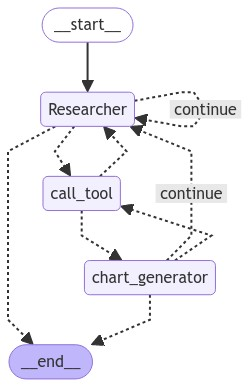

In [61]:
from IPython.display import Image,display

display(Image(Tesla_coil.get_graph(xray = True).draw_mermaid_png()))

In [62]:
events = Tesla_coil.stream(
    {
        "messages": [
            HumanMessage(
                content="Fetch India's GDP over the past decade, then draw a line graph of it. Once you code it up, finish"
            )
        ],
    },
    {"recursion_limit": 150},
)

for s in events:
    print(s)
    print("----------------")

{'Researcher': {'messages': [AIMessage(content='', additional_kwargs={'usage': {'prompt_tokens': 410, 'completion_tokens': 66, 'total_tokens': 476}, 'stop_reason': 'tool_use', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'}, response_metadata={'usage': {'prompt_tokens': 410, 'completion_tokens': 66, 'total_tokens': 476}, 'stop_reason': 'tool_use', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'}, name='Researcher', id='run-e646ca0a-241f-4a8d-ad4c-dbf25dcbea86-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'India GDP by year last 10 years'}, 'id': 'toolu_bdrk_01Ai9BNjk5AF6bUYJQaKjemZ', 'type': 'tool_call'}], usage_metadata={'input_tokens': 410, 'output_tokens': 66, 'total_tokens': 476})], 'sender': 'Researcher'}}
----------------
{'call_tool': {'messages': [ToolMessage(content='[{"url": "https://tradingeconomics.com/india/gdp-growth-annual", "content": "GDP Annual Growth Rate in India averaged 5.93 percent from 1951 until 2023, reaching an all time

ValueError: Error raised by bedrock service: An error occurred (ValidationException) when calling the InvokeModel operation: Your API request included an `assistant` message in the final position, which would pre-fill the `assistant` response. When using tools, pre-filling the `assistant` response is not supported.